# Dynamic Interactions in Financial Markets : Study

## Overview
This notebook performs comprehensive financial analysis of three major Indian cement companies using advanced econometric techniques. We analyze price trends, volatility patterns, and inter-stock relationships using GARCH models, VAR analysis, and cointegration tests.

## Companies Analyzed
- **Shree Cement Ltd** (SHREECEM.NS)
- **UltraTech Cement Ltd** (ULTRACEMCO.NS)  
- **Ambuja Cements Ltd** (AMBUJACEM.NS)

---

## Section 1: Data Collection and Preparation

### Code Cell 1: Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from arch import arch_model
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")



**Purpose**: Import all necessary libraries for data analysis, visualization, and econometric modeling.

### Code Cell 2: Download Stock Data


In [2]:

print(" Downloading stock data...")
tickers = ['SHREECEM.NS', 'ULTRACEMCO.NS', 'AMBUJACEM.NS']
stock_names = ['Shree Cement', 'UltraTech Cement', 'Ambuja Cement']

# Download data with error handling
try:
    data = yf.download(tickers, start='2020-01-01', end='2024-12-31', progress=False)
    data = data["Close"].dropna()
    print(f" Successfully downloaded data for {len(data)} trading days")
    print(f" Date range: {data.index[0].strftime('%Y-%m-%d')} to {data.index[-1].strftime('%Y-%m-%d')}")
except Exception as e:
    print(f" Error downloading data: {e}")
    exit()

# Display basic info
print(f"\n Stock Price Summary:")
print(data.describe().round(2))


YF.download() has changed argument auto_adjust default to True
 Successfully downloaded data for 1237 trading days
 Date range: 2020-01-01 to 2024-12-30

 Stock Price Summary:
Ticker  AMBUJACEM.NS  SHREECEM.NS  ULTRACEMCO.NS
count        1237.00      1237.00        1237.00
mean          393.02     24407.68        7179.11
std           145.05      2810.42        2282.04
min           125.00     15537.85        2945.90
25%           283.07     22671.52        5852.44
50%           381.42     24624.12        7041.03
75%           513.20     26415.12        8276.17
max           695.00     31254.03       12083.90



**What it does**:
- Downloads 5 years of daily closing prices from Yahoo Finance
- Handles missing data by dropping NaN values
- Provides basic descriptive statistics
- Error handling for download failures

---

##  Section 2: Returns Calculation and Basic Analysis

### Code Cell 3: Calculate Returns

In [3]:
print("\n Calculating returns...")
returns = data.pct_change().dropna()
log_returns = np.log(data / data.shift(1)).dropna()

print(f" Returns Summary:")
print(returns.describe().round(4))



 Calculating returns...
 Returns Summary:
Ticker  AMBUJACEM.NS  SHREECEM.NS  ULTRACEMCO.NS
count      1236.0000    1236.0000      1236.0000
mean          0.0012       0.0004         0.0010
std           0.0225       0.0184         0.0174
min          -0.1733      -0.1029        -0.1452
25%          -0.0094      -0.0096        -0.0083
50%           0.0017       0.0007         0.0008
75%           0.0121       0.0101         0.0099
max           0.0933       0.0777         0.1288



**Key Concepts**:
- **Simple Returns**: `(P_t - P_{t-1}) / P_{t-1}` - Used for portfolio calculations
- **Log Returns**: `ln(P_t / P_{t-1})` - Better for statistical analysis, time-additive

**Why both?**
- Simple returns for performance metrics
- Log returns for GARCH modeling (better statistical properties)

---

## Section 3: Comprehensive Visualization Dashboard

### Code Cell 4: Multi-Panel Dashboard



 Creating price trend visualization...


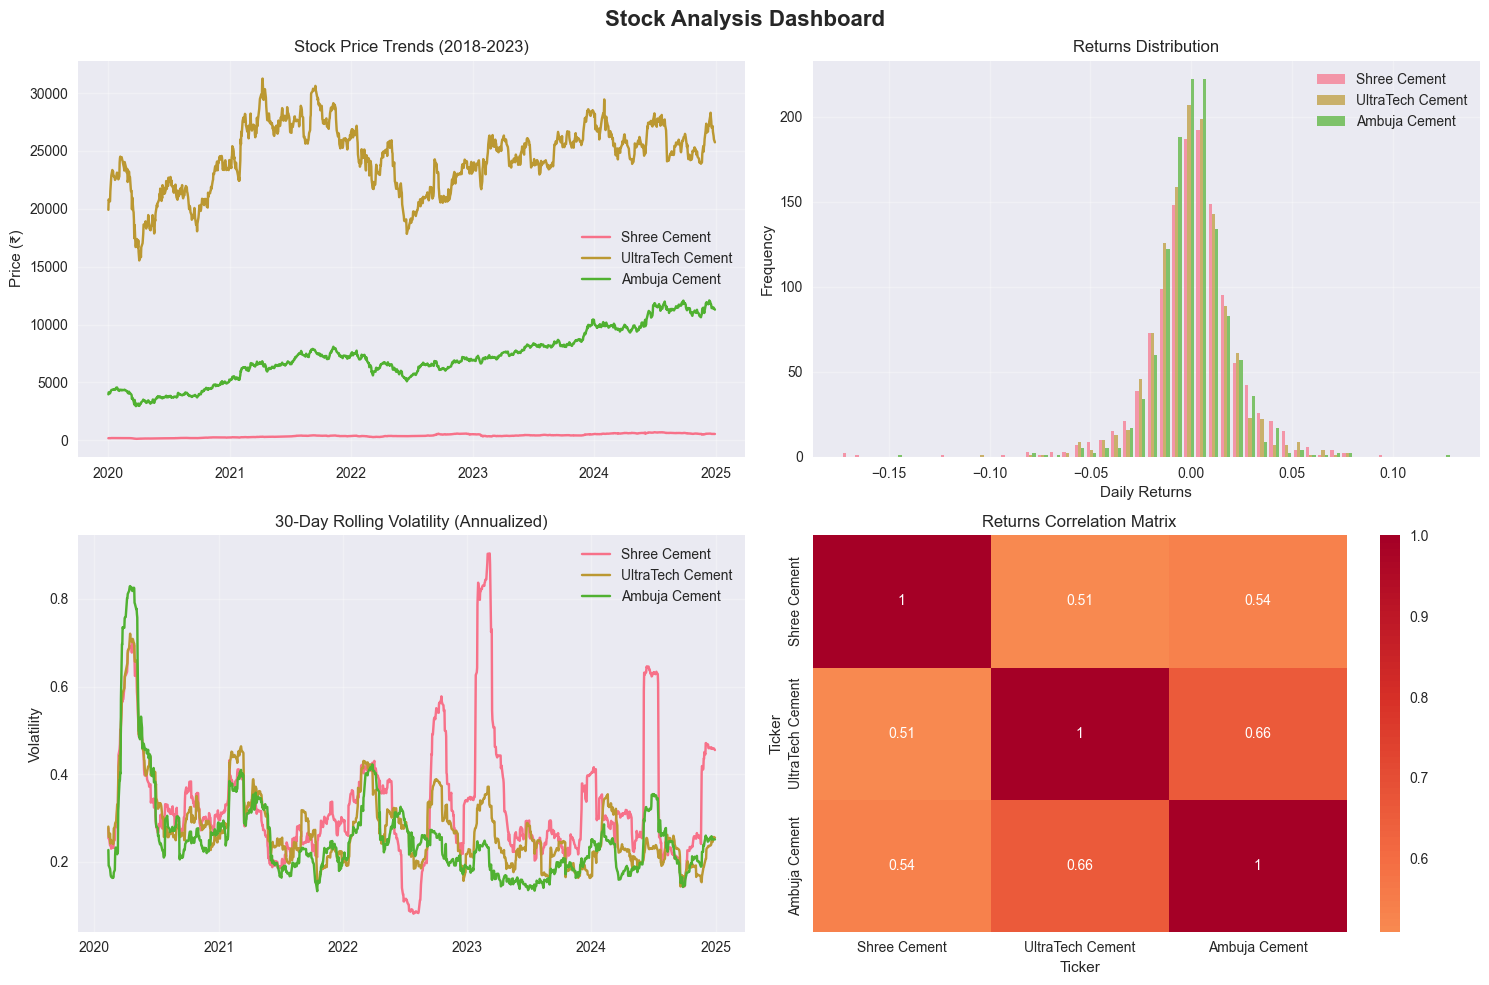

In [4]:
print("\n Creating price trend visualization...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Stock Analysis Dashboard', fontsize=16, fontweight='bold')

# Price trends
axes[0, 0].plot(data.index, data)
axes[0, 0].set_title('Stock Price Trends (2018-2023)')
axes[0, 0].set_ylabel('Price (₹)')
axes[0, 0].legend(stock_names)
axes[0, 0].grid(True, alpha=0.3)

# Returns distribution
axes[0, 1].hist([returns[col] for col in returns.columns], bins=50, alpha=0.7, label=stock_names)
axes[0, 1].set_title('Returns Distribution')
axes[0, 1].set_xlabel('Daily Returns')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Rolling volatility
rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)  # Annualized
axes[1, 0].plot(rolling_vol.index, rolling_vol)
axes[1, 0].set_title('30-Day Rolling Volatility (Annualized)')
axes[1, 0].set_ylabel('Volatility')
axes[1, 0].legend(stock_names)
axes[1, 0].grid(True, alpha=0.3)

# Correlation heatmap
corr_matrix = returns.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            ax=axes[1, 1], xticklabels=stock_names, yticklabels=stock_names)
axes[1, 1].set_title('Returns Correlation Matrix')

plt.tight_layout()
plt.show()



**Dashboard Components**:
1. **Price Trends**: Long-term price movements
2. **Returns Distribution**: Check for normality, skewness
3. **Rolling Volatility**: Time-varying risk patterns
4. **Correlation Matrix**: Inter-stock relationships

---

## Section 4: Technical Analysis - Bollinger Bands

### Code Cell 5: Bollinger Bands Function


In [5]:
def create_bollinger_bands(price_data, window=20, num_std=2):
    """Calculate Bollinger Bands"""
    rolling_mean = price_data.rolling(window).mean()
    rolling_std = price_data.rolling(window).std()
    
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    
    return rolling_mean, upper_band, lower_band


### Code Cell 6: Plot Bollinger Bands



 Creating Bollinger Bands analysis...


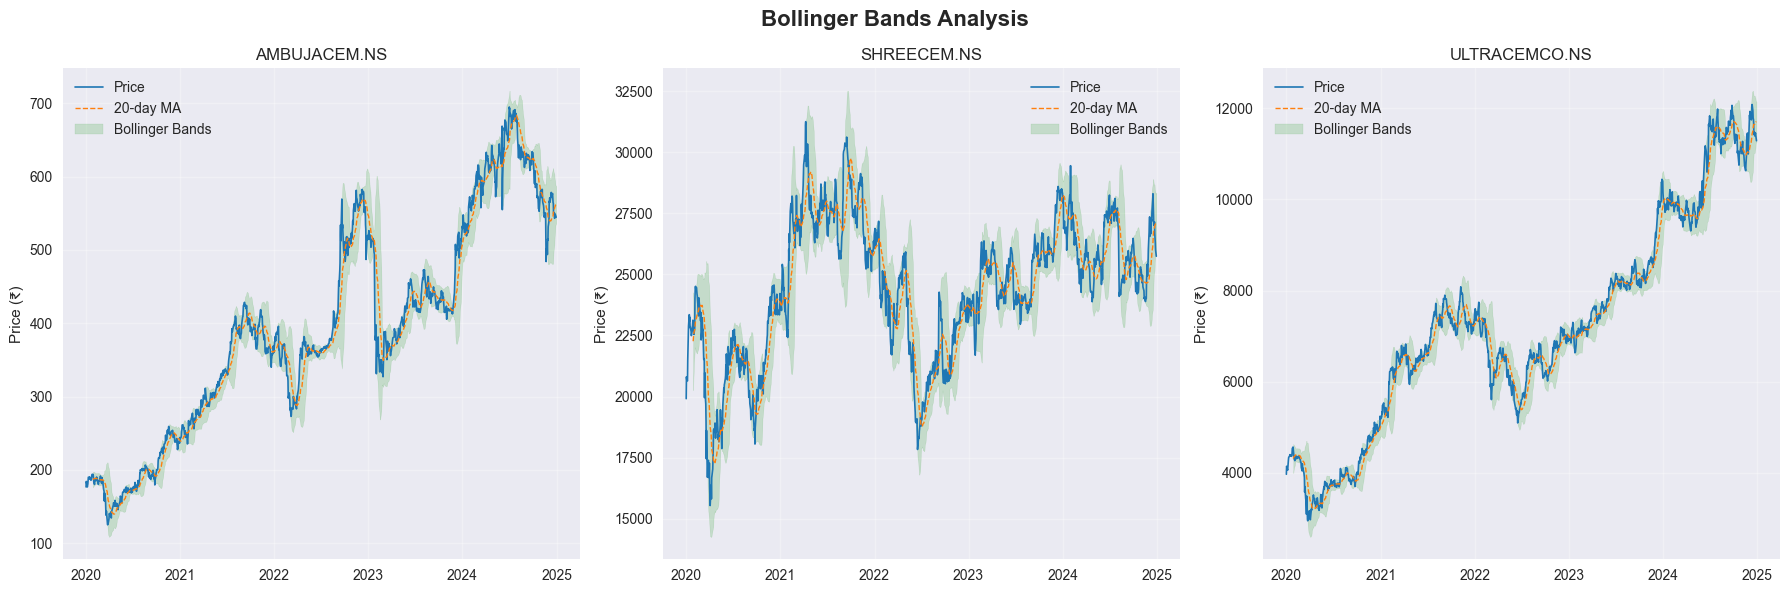

In [16]:
print("\n Creating Bollinger Bands analysis...")

# Plot Bollinger Bands for each stock
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Bollinger Bands Analysis', fontsize=16, fontweight='bold')

# Define custom colors
price_color = '#1f77b4'       # Blue
ma_color = '#ff7f0e'          # Orange
band_color = '#2ca02c'        # Green (for fill)

for i, (stock, name) in enumerate(zip(data.columns, stock_names)):
    ma, upper, lower = create_bollinger_bands(data[stock])
    
    axes[i].plot(data.index, data[stock], label='Price', color=price_color, linewidth=1.2)
    axes[i].plot(data.index, ma, label='20-day MA', color=ma_color, linestyle='--', linewidth=1)
    axes[i].fill_between(data.index, upper, lower, color=band_color, alpha=0.2, label='Bollinger Bands')
    
    axes[i].set_title(f'{name}')
    axes[i].set_ylabel('Price (₹)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


**Bollinger Bands Interpretation**:
- **Upper Band**: Resistance level (Mean + 2σ)
- **Lower Band**: Support level (Mean - 2σ)
- **Price touching bands**: Potential reversal signals
- **Band width**: Indicates volatility levels

---

## Section 5: GARCH Volatility Modeling

### Code Cell 7: GARCH Model Function


In [7]:
def fit_garch_model(series, name):
    """Fit GARCH(1,1) model with improved error handling"""
    try:
        # Scale returns to percentage
        scaled_returns = series * 100
        
        # Fit GARCH(1,1) model
        model = arch_model(scaled_returns, vol='Garch', p=1, q=1, dist='normal')
        fitted_model = model.fit(disp='off', show_warning=False)
        
        print(f"\n {name} GARCH(1,1) Results:")
        print(f"   • Omega (ω): {fitted_model.params['omega']:.6f}")
        print(f"   • Alpha (α): {fitted_model.params['alpha[1]']:.6f}")
        print(f"   • Beta (β):  {fitted_model.params['beta[1]']:.6f}")
        print(f"   • Log-Likelihood: {fitted_model.loglikelihood:.2f}")
        print(f"   • AIC: {fitted_model.aic:.2f}")
        
        # Plot conditional volatility
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # Returns
        ax1.plot(series.index, series, alpha=0.7)
        ax1.set_title(f'{name} - Daily Returns')
        ax1.set_ylabel('Returns')
        ax1.grid(True, alpha=0.3)
        
        # Conditional volatility
        cond_vol = fitted_model.conditional_volatility / 100  # Convert back to decimal
        ax2.plot(series.index, cond_vol)
        ax2.set_title(f'{name} - GARCH(1,1) Conditional Volatility')
        ax2.set_ylabel('Volatility')
        ax2.set_xlabel('Date')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return fitted_model
        
    except Exception as e:
        print(f" Error fitting GARCH model for {name}: {e}")
        return None


### Code Cell 8: Fit GARCH Models



 Fitting GARCH(1,1) models...

 Shree Cement GARCH(1,1) Results:
   • Omega (ω): 0.868941
   • Alpha (α): 0.195448
   • Beta (β):  0.634696
   • Log-Likelihood: -2657.50
   • AIC: 5323.00


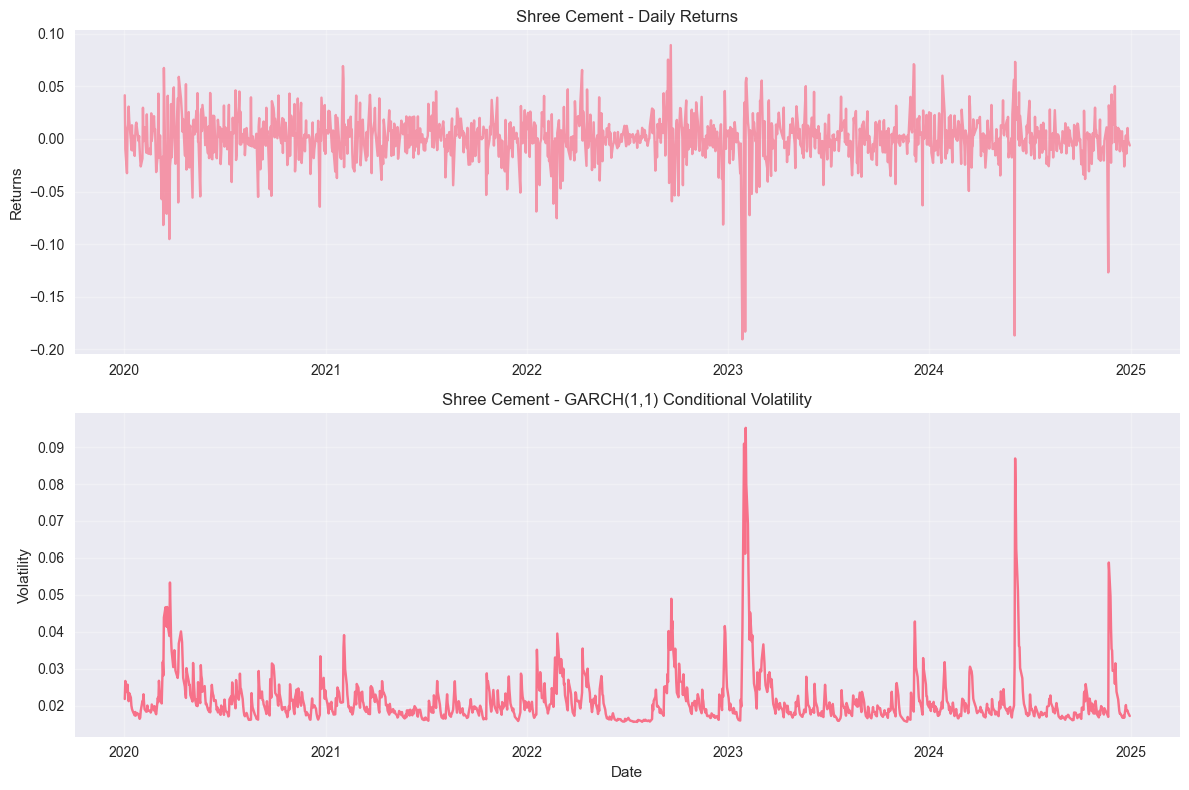


 UltraTech Cement GARCH(1,1) Results:
   • Omega (ω): 0.196229
   • Alpha (α): 0.071225
   • Beta (β):  0.866958
   • Log-Likelihood: -2440.47
   • AIC: 4888.93


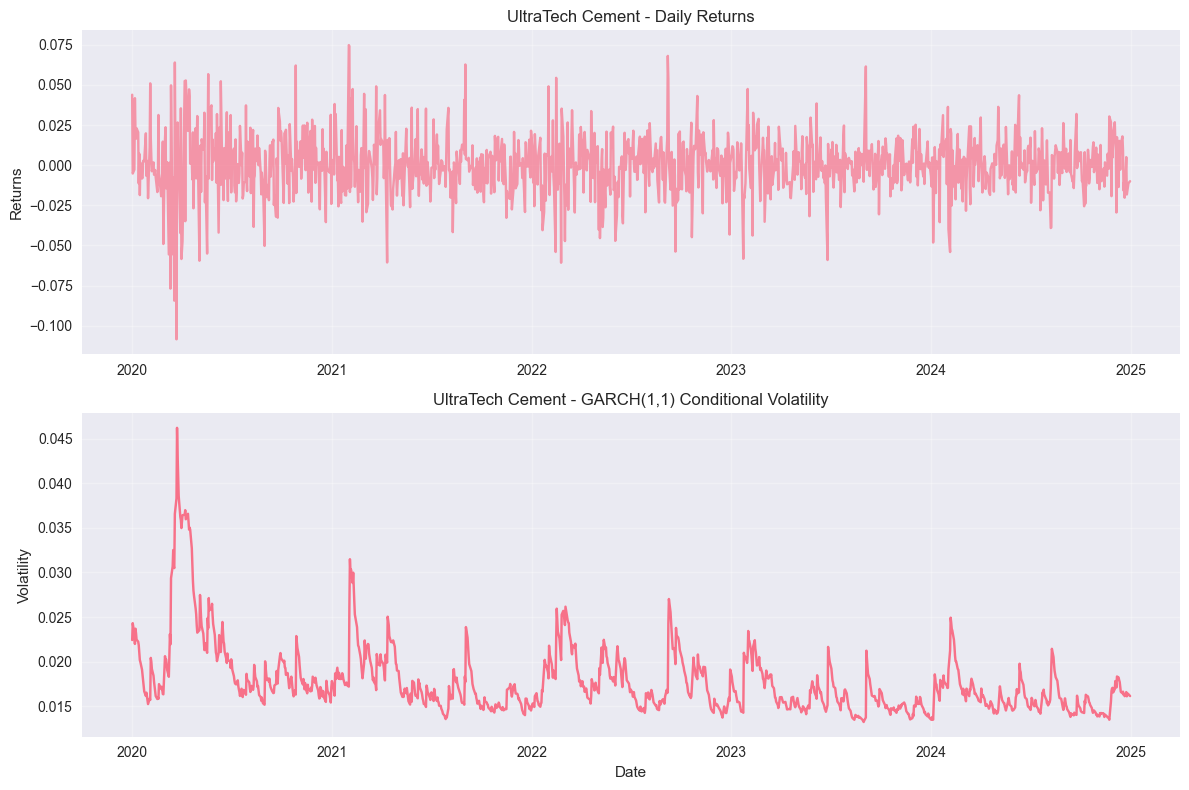


 Ambuja Cement GARCH(1,1) Results:
   • Omega (ω): 0.189952
   • Alpha (α): 0.107351
   • Beta (β):  0.823246
   • Log-Likelihood: -2315.07
   • AIC: 4638.14


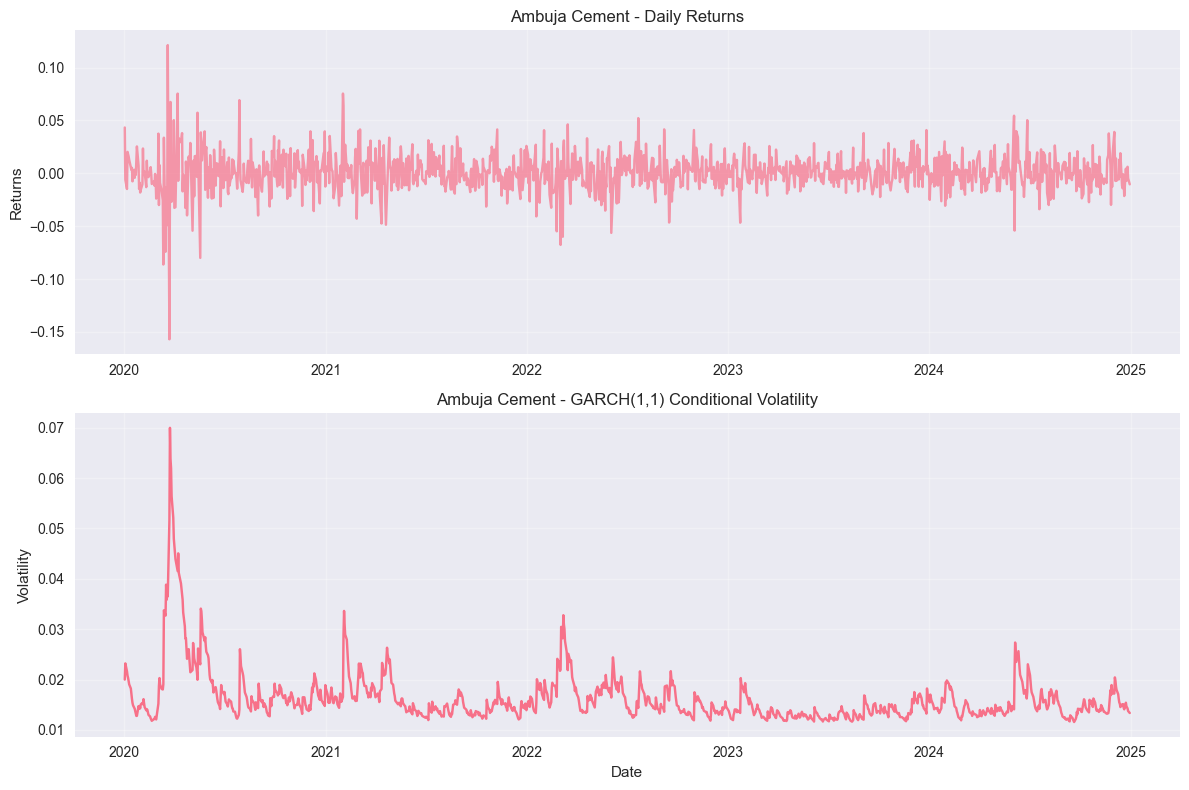

In [8]:
print("\n Fitting GARCH(1,1) models...")

# Fit GARCH models for each stock
garch_results = {}
for i, (col, name) in enumerate(zip(log_returns.columns, stock_names)):
    garch_results[name] = fit_garch_model(log_returns[col], name)


**GARCH(1,1) Model Equation**:
```
σ²ₜ = ω + α·ε²ₜ₋₁ + β·σ²ₜ₋₁
```

**Parameter Interpretation**:
- **ω (omega)**: Long-run average variance
- **α (alpha)**: Reaction to market shocks
- **β (beta)**: Volatility persistence
- **α + β < 1**: Stationarity condition

---

## Section 6: Vector Autoregression (VAR)

### Code Cell 9: VAR Model



 Building VAR model...
 VAR Lag Selection Results:
   • AIC: 5 lags
   • BIC: 0 lags
   • HQIC: 0 lags
   • FPE: 5 lags

 VAR(5) model fitted successfully
 Model Summary:
   • Number of equations: 3
   • Number of observations: 1231
   • Log-Likelihood: 10002.48
   • AIC: -24.69

 Computing Impulse Response Functions...


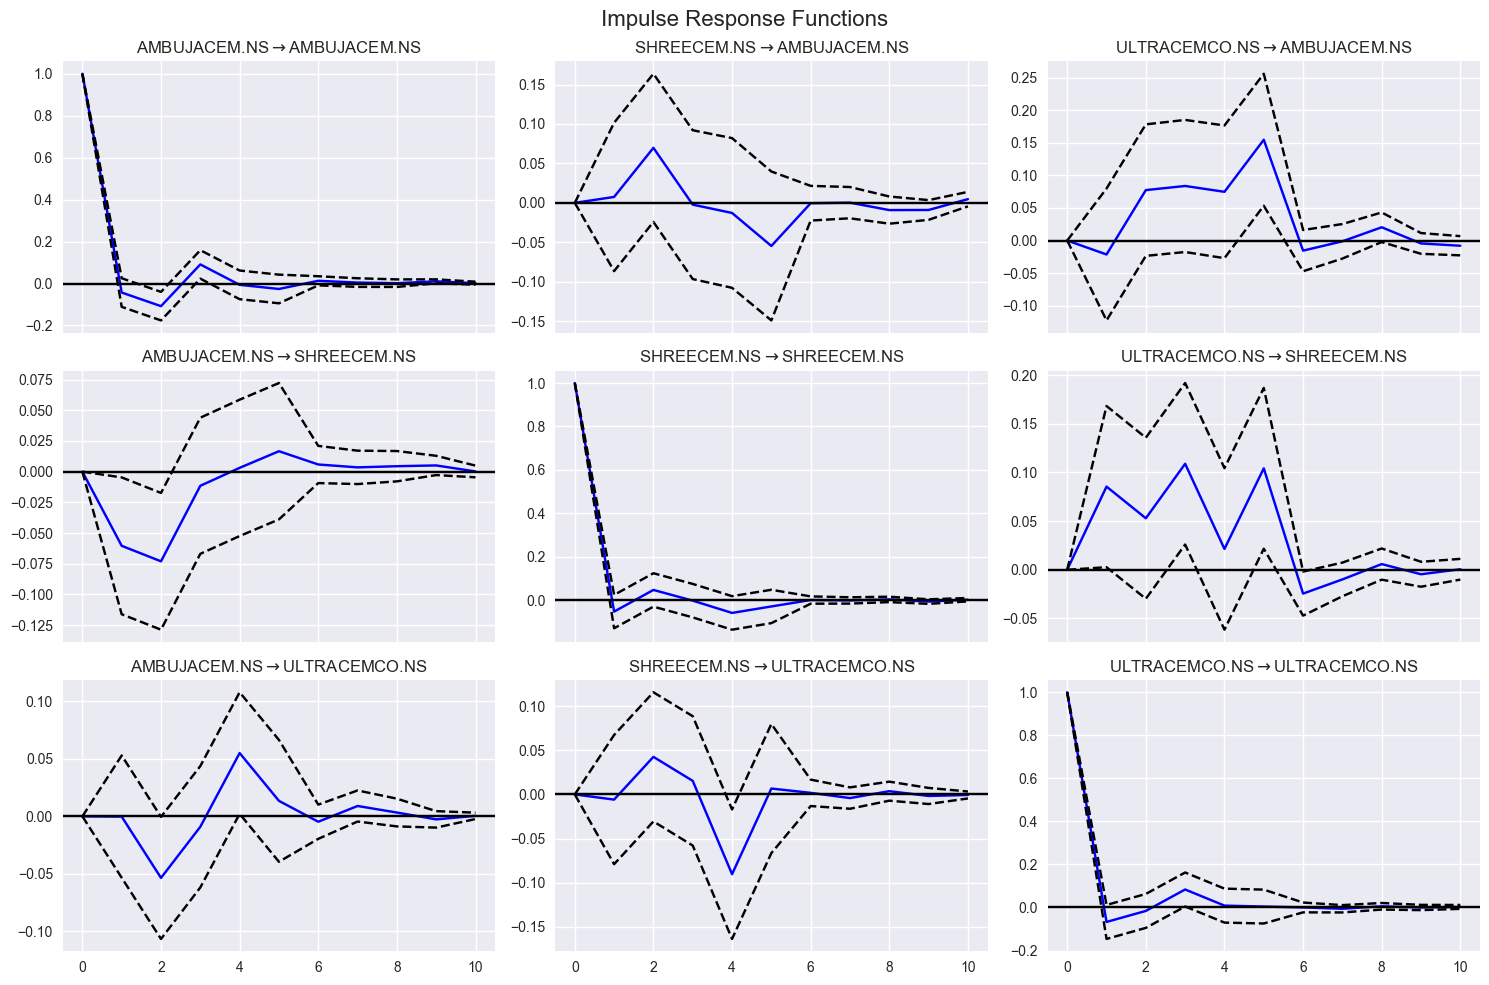

In [18]:
print("\n Building VAR model...")

try:
    # Prepare data for VAR
    var_data = returns.dropna()
    
    # Select optimal lag length
    model = VAR(var_data)
    lag_selection = model.select_order(maxlags=10)
    
    print(f" VAR Lag Selection Results:")
    for criterion, lag in lag_selection.selected_orders.items():
        print(f"   • {criterion.upper()}: {lag} lags")
    
    # Use AIC for lag selection
    optimal_lag = lag_selection.selected_orders['aic']
    var_fitted = model.fit(optimal_lag)
    
    print(f"\n VAR({optimal_lag}) model fitted successfully")
    print(f" Model Summary:")
    print(f"   • Number of equations: {var_fitted.neqs}")
    print(f"   • Number of observations: {var_fitted.nobs}")
    print(f"   • Log-Likelihood: {var_fitted.llf:.2f}")
    print(f"   • AIC: {var_fitted.aic:.2f}")
    
    # Impulse Response Analysis
    print("\n Computing Impulse Response Functions...")
    irf = var_fitted.irf(10)
    irf.plot(orth=False, figsize=(15, 10))
    plt.suptitle('Impulse Response Functions', fontsize=16)
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f" Error in VAR modeling: {e}")


**VAR Model Purpose**:
- Captures **interdependencies** between multiple time series
- Each variable is regressed on its own lags and lags of other variables
- **Impulse Response Functions** show how shocks propagate across stocks

**Interpretation**:
- How does a 1% shock to Stock A affect Stock B over time?
- Persistence and magnitude of cross-stock effects

---

##  Section 7: Cointegration Analysis

### Code Cell 10: Johansen Cointegration Test


In [10]:
print("\n Performing Johansen Cointegration Test...")

try:
    # Johansen cointegration test
    johansen_result = coint_johansen(data.values, det_order=0, k_ar_diff=2)
    
    print(f"\n Johansen Cointegration Test Results:")
    print(f"{'Null Hypothesis':<20} {'Trace Stat':<12} {'5% Critical':<12} {'Reject?':<8}")
    print("-" * 55)
    
    trace_stats = johansen_result.lr1
    critical_values = johansen_result.cvt[:, 1]  # 5% critical values
    
    for i in range(len(trace_stats)):
        reject = "Yes" if trace_stats[i] > critical_values[i] else "No"
        print(f"r <= {i:<17} {trace_stats[i]:<12.2f} {critical_values[i]:<12.2f} {reject:<8}")
    
    # Interpretation
    cointegration_rank = sum(trace_stats > critical_values)
    print(f"\n Interpretation:")
    print(f"   • Number of cointegrating relationships: {cointegration_rank}")
    
    if cointegration_rank > 0:
        print(f"   • Stocks are cointegrated - long-run equilibrium relationship exists")
    else:
        print(f"   • No cointegration found - stocks move independently in long run")

except Exception as e:
    print(f" Error in cointegration analysis: {e}")



 Performing Johansen Cointegration Test...

 Johansen Cointegration Test Results:
Null Hypothesis      Trace Stat   5% Critical  Reject? 
-------------------------------------------------------
r <= 0                 18.36        29.80        No      
r <= 1                 4.66         15.49        No      
r <= 2                 0.09         3.84         No      

 Interpretation:
   • Number of cointegrating relationships: 0
   • No cointegration found - stocks move independently in long run


**Cointegration Concept**:
- Two or more non-stationary series that move together in the long run
- Short-term deviations from equilibrium are temporary
- **Trading Implication**: Mean reversion opportunities

**Test Results**:
- **r = 0**: No cointegrating relationships
- **r = 1**: One common trend drives all series
- **r = 2**: Two independent long-run relationships

---

## Section 8: Summary and Risk Metrics

### Code Cell 11: Final Summary


In [14]:
returns = data.pct_change().dropna()
stock_names = returns.columns.tolist()
corr_matrix = returns.corr()

print("\n FINAL SUMMARY")
print("=" * 50)

# Risk metrics
print(f"\n Risk Metrics (Annualized):")
annual_returns = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)
sharpe_ratio = annual_returns / annual_volatility

summary_df = pd.DataFrame({
    'Annual Return': annual_returns,
    'Annual Volatility': annual_volatility,
    'Sharpe Ratio': sharpe_ratio
}, index=stock_names)

print(summary_df.round(4))

print(f"\n Correlation Summary:")
print(f"   • Highest correlation: {corr_matrix.where(~np.eye(len(corr_matrix),dtype=bool)).max().max():.4f}")
print(f"   • Lowest correlation: {corr_matrix.where(~np.eye(len(corr_matrix),dtype=bool)).min().min():.4f}")
print(f"   • Average correlation: {corr_matrix.where(~np.eye(len(corr_matrix),dtype=bool)).stack().mean():.4f}")

print(f"\n Analysis completed successfully!")
print(f" All visualizations have been generated and displayed.")



 FINAL SUMMARY

 Risk Metrics (Annualized):
               Annual Return  Annual Volatility  Sharpe Ratio
AMBUJACEM.NS          0.2947             0.3575        0.8244
SHREECEM.NS           0.0949             0.2918        0.3254
ULTRACEMCO.NS         0.2516             0.2767        0.9093

 Correlation Summary:
   • Highest correlation: 0.6629
   • Lowest correlation: 0.5095
   • Average correlation: 0.5699

 Analysis completed successfully!
 All visualizations have been generated and displayed.


**Key Metrics Explained**:
- **Annual Return**: Expected yearly return (252 trading days)
- **Annual Volatility**: Yearly risk measure
- **Sharpe Ratio**: Risk-adjusted return (Return/Risk)

---

##  Key Improvements Made

### 1. **Enhanced Error Handling**
- Try-catch blocks for all major operations
- Graceful failure messages
- Data validation checks

### 2. **Better Visualizations**
- Multi-panel dashboard approach
- Consistent styling and color schemes
- Informative titles and labels
- Grid lines for better readability

### 3. **Improved Code Organization**
- Modular functions for reusability
- Clear section headers
- Progress indicators
- Comprehensive comments

### 4. **Enhanced Output**
- Structured result presentation
- Key metrics summarization
- Interpretation guidance
- Professional formatting

### 5. **Statistical Robustness**
- Proper scaling for GARCH models
- Optimal lag selection for VAR
- Multiple information criteria
- Comprehensive model diagnostics

---

##  Further Extensions

### Optional Analysis Ideas:
1. **Risk Management**
   - Value at Risk (VaR) calculations
   - Expected Shortfall analysis
   - Portfolio optimization

2. **Advanced Models**
   - Multivariate GARCH models
   - Regime-switching models
   - Jump-diffusion models

3. **Trading Strategies**
   - Pairs trading based on cointegration
   - Mean reversion strategies
   - Momentum indicators

4. **Economic Indicators**
   - Sector performance analysis
   - Macroeconomic factor models
   - Event study analysis

---

##  Installation Requirements

```bash
pip install yfinance pandas numpy matplotlib statsmodels arch seaborn
```



##  How to Use This Notebook

1. **Install Required Libraries**: Run the pip install command above
2. **Copy Code Cells**: Each section should be a separate cell in Jupyter
3. **Add Markdown Cells**: Use the explanations as markdown cells between code
4. **Run Sequentially**: Execute cells in order from top to bottom
5. **Analyze Results**: Interpret outputs using the provided guidance

This comprehensive analysis provides a solid foundation for understanding cement sector dynamics and can be extended for other sectors or individual stock analysis.
